# 01 · Feature Engineering

Pull full-history SPX/USD 1-minute data, validate it, and persist engineered factors for downstream modeling.


**Workflow**
- Ensure `00_environment.ipynb` ran successfully
- Use HistData.com API to download SPX/USD M1 bars (cached under `data/prices.csv`)
- Compute momentum, volatility, and oscillator features
- Persist the final feature panel to `data/features.csv`


In [ ]:
# Add parent directory to path for module imports
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd

from momentum_lib import bootstrap_env, validate_prices, compute_features
from histdata_loader import ensure_histdata_prices

bootstrap_env(Path("../.env"))
print("Environment primed.")

data_dir = Path("../data")
data_dir.mkdir(exist_ok=True)
cache_file = data_dir / "prices.csv"
# Note: SPXUSD data on HistData.com is only available from 2019 onwards
# Earlier years will show warnings but won't affect the download
START_YEAR = 2019  
# Set to False after first run to use cached data
REBUILD = True

In [ ]:
print("=" * 60)
print("LOADING PRICE DATA")
print("=" * 60)

# Note: First run downloads ~6 years of SPXUSD data (2019-2024) and caches zip files.
# Subsequent runs reuse cached downloads and are much faster!
# To force re-download, delete data/histdata_cache/ directory

prices = ensure_histdata_prices(
    output_path=cache_file,
    start_year=START_YEAR,
    rebuild=REBUILD,
    verbose=True,  # Enable progress updates
)
prices = validate_prices(prices)
print(f"\n{'=' * 60}")
print(f"[OK] Data range: {prices.index.min()} to {prices.index.max()}")
print(f"[OK] Total rows: {len(prices):,}")
print(f"{'=' * 60}\n")
prices.head()

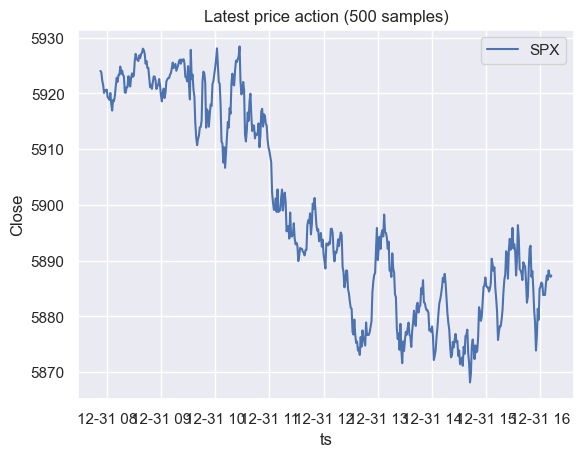

,SPX
ts,
2024-12-31 16:08:00-05:00,5886.579
2024-12-31 16:09:00-05:00,5888.247
2024-12-31 16:10:00-05:00,5887.377
2024-12-31 16:11:00-05:00,5887.079
2024-12-31 16:12:00-05:00,5887.323


In [6]:
# Import visualization libraries only when needed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

recent = prices.tail(500)
ax = sns.lineplot(data=recent)
ax.set_title("Latest price action (500 samples)")
ax.set_ylabel("Close")
plt.show()
recent.tail()

In [7]:
print("=" * 60)
print("COMPUTING FEATURES")
print("=" * 60)

features = compute_features(prices)

print(f"\n[OK] Features computed: {features.shape[1]} columns, {features.shape[0]:,} rows")

feature_file = data_dir / "features.csv"
print(f"Saving to {feature_file}...")
features.to_csv(feature_file, index=True)

print(f"[OK] Feature panel saved")
print(f"{'=' * 60}\n")

features.describe().T.head()

COMPUTING FEATURES

[OK] Features computed: 6 columns, 1,943,340 rows
Saving to ..\data\features.csv...
[OK] Feature panel saved



,count,mean,std,min,25%,50%,75%,max
SPX_ret_1,1943340.0,4.995580e-07,0.000352,-0.073341,-0.000103,0.000000,0.000105,0.027429
SPX_ema_short,1943340.0,4.044457e+03,867.584138,2188.346939,3292.424784,4077.092042,4526.623329,6097.763705
SPX_ema_long,1943340.0,4.044444e+03,867.578505,2192.080701,3292.339003,4077.032971,4526.687223,6097.157560
SPX_ema_ratio,1943340.0,1.000003e+00,0.000521,0.963961,0.999856,1.000012,1.000166,1.020041
SPX_vol_10,1943340.0,2.211152e-04,0.000251,0.000000,0.000093,0.000152,0.000263,0.023302


Generating correlation heatmap...


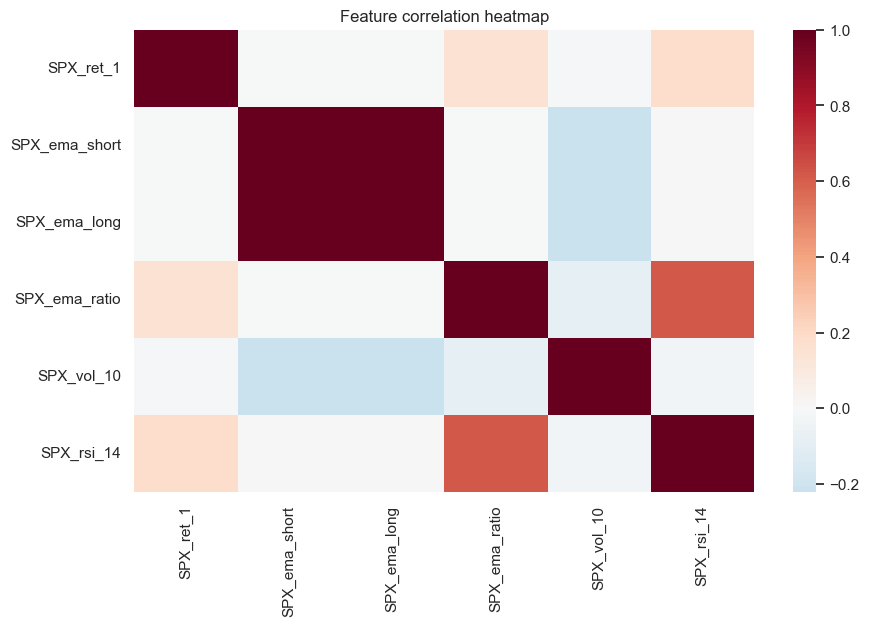

In [8]:
# Ensure matplotlib is imported
if 'plt' not in dir():
    import matplotlib.pyplot as plt
    import seaborn as sns

print("Generating correlation heatmap...")
corr = features.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap="RdBu_r", center=0)
plt.title("Feature correlation heatmap")
plt.show()
